In [1]:
import pandas as pd 
import numpy as np 
import spacy
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
import h5py


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import re 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import fasttext

# Data analysis and manupilation

In [3]:
df = pd.read_csv('resume_df')
df = df[['txt','lab']]
df['cleaned_lab'] = df['lab'].str.split(' ,')
df.head()

,txt,lab,cleaned_lab
0,"Database Administrator <span class=""hl"">Databa...",Database_Administrator,[Database_Administrator]
1,"Database Administrator <span class=""hl"">Databa...",Database_Administrator,[Database_Administrator]
2,Oracle Database Administrator Oracle <span cla...,Database_Administrator,[Database_Administrator]
3,Amazon Redshift Administrator and ETL Develope...,Database_Administrator,[Database_Administrator]
4,Scrum Master Scrum Master Scrum Master Richmon...,Database_Administrator,[Database_Administrator]


In [4]:
## to get all the unique labels present in Dataframe
unique_labels = []
for row in df['cleaned_lab']:
    for label in row:
        if label not in unique_labels:
            unique_labels.append(label)



## mapping each label to a integer
label_mapping = {}
for indx,label in enumerate(unique_labels):
    label_mapping[label] = indx

print(label_mapping)



# onehotencoding of the output features
def map_label(label_list):
    label_encoded = np.array([label_mapping[label] for label in label_list])
    label_vector = np.zeros(shape=(10), dtype = 'int8')
    
    for label in label_encoded:
        label_vector[label] = 1
        
    return label_vector

{'Database_Administrator': 0, 'Software_Developer': 1, 'Systems_Administrator': 2, 'Project_manager': 3, 'Security_Analyst': 4, 'Web_Developer': 5, 'Network_Administrator': 6, 'Front_End_Developer': 7, 'Java_Developer': 8, 'Python_Developer': 9}


In [5]:
df['cleaned_lab'] = df['cleaned_lab'].apply(map_label)
df.head()

,txt,lab,cleaned_lab
0,"Database Administrator <span class=""hl"">Databa...",Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"Database Administrator <span class=""hl"">Databa...",Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Oracle Database Administrator Oracle <span cla...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Amazon Redshift Administrator and ETL Develope...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Scrum Master Scrum Master Scrum Master Richmon...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [6]:
df

,txt,lab,cleaned_lab
0,"Database Administrator <span class=""hl"">Databa...",Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"Database Administrator <span class=""hl"">Databa...",Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Oracle Database Administrator Oracle <span cla...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Amazon Redshift Administrator and ETL Develope...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Scrum Master Scrum Master Scrum Master Richmon...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...
29030,"ServiceNow Developer ServiceNow <span class=""h...","Java_Developer ,Web_Developer ,Software_Developer","[0, 1, 0, 0, 0, 1, 0, 0, 1, 0]"
29031,"Android Developer Android <span class=""hl"">Dev...","Web_Developer ,Software_Developer","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]"
29032,"UI Developer UI <span class=""hl"">Developer</sp...","Software_Developer ,Front_End_Developer ,Web_D...","[0, 1, 0, 0, 0, 1, 0, 1, 0, 0]"
29033,"Web Developer <span class=""hl"">Web</span> <spa...","Web_Developer ,Software_Developer","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]"


In [7]:
# check = np.array([0,0,0,0,0,0,0,0,0,0])
# for i in range(len(df)):
#     if np.array_equal(df['cleaned_lab'][i], check):
#         print(i)
# # df['cleaned_lab'][0]

In [8]:
def clean_txt(text):
    '''
    function to clean the text
    -- lowercasing the text, removing email ids and website links, stop words and special characters
    -- also it will do lemmi
    tization of the words for better accuray of our model. 
    '''
    # Remove sentences that start with '<span' and end with 'span>'
    cleaned_text = re.sub(r'<span.*?span>', '', text.strip())

    cleaned_text = cleaned_text.lower()# Lowercasing

    cleaned_text = re.sub(r'http\S+|www\S+|https\S+', '', cleaned_text, flags=re.MULTILINE)# Removing hyperlinks

    cleaned_text = re.sub(r'\S+@\S+', '', cleaned_text, flags=re.MULTILINE)# Removing email addresses

    # Removing special characters, numbers, and punctuation
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text)

    # Tokenization
    tokens = word_tokenize(cleaned_text.strip())

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [9]:
df['cleaned_txt'] = df['txt'].apply(clean_txt)

In [15]:
# df[['cleaned_txt','lab','cleaned_lab']].to_csv('Cleaned_Resumes_n_lab.csv')

In [15]:
df

,txt,lab,cleaned_lab,cleaned_txt
0,"Database Administrator <span class=""hl"">Databa...",Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",database administrator database administrator ...
1,"Database Administrator <span class=""hl"">Databa...",Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",database administrator sql server database adm...
2,Oracle Database Administrator Oracle <span cla...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",oracle database administrator oracle oracle da...
3,Amazon Redshift Administrator and ETL Develope...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",amazon redshift administrator etl developer bu...
4,Scrum Master Scrum Master Scrum Master Richmon...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",scrum master scrum master scrum master richmon...
...,...,...,...,...
29030,"ServiceNow Developer ServiceNow <span class=""h...","Java_Developer ,Web_Developer ,Software_Developer","[0, 1, 0, 0, 0, 1, 0, 0, 1, 0]",servicenow developer servicenow servicenow dev...
29031,"Android Developer Android <span class=""hl"">Dev...","Web_Developer ,Software_Developer","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]",android developer android android developer hc...
29032,"UI Developer UI <span class=""hl"">Developer</sp...","Software_Developer ,Front_End_Developer ,Web_D...","[0, 1, 0, 0, 0, 1, 0, 1, 0, 0]",ui developer ui ui developer cotiviti health c...
29033,"Web Developer <span class=""hl"">Web</span> <spa...","Web_Developer ,Software_Developer","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]",web developer los angeles ca work experience w...


In [10]:
lengths = df['cleaned_txt'].str.split(' ')
str_lengths = np.array([len(row) for row in lengths])
str_lengths

array([ 774,  205,  372, ..., 1869,   84,  479])

In [12]:
# df.to_csv('cleaned_labels_resumes.csv')

max words in a resume -  9493


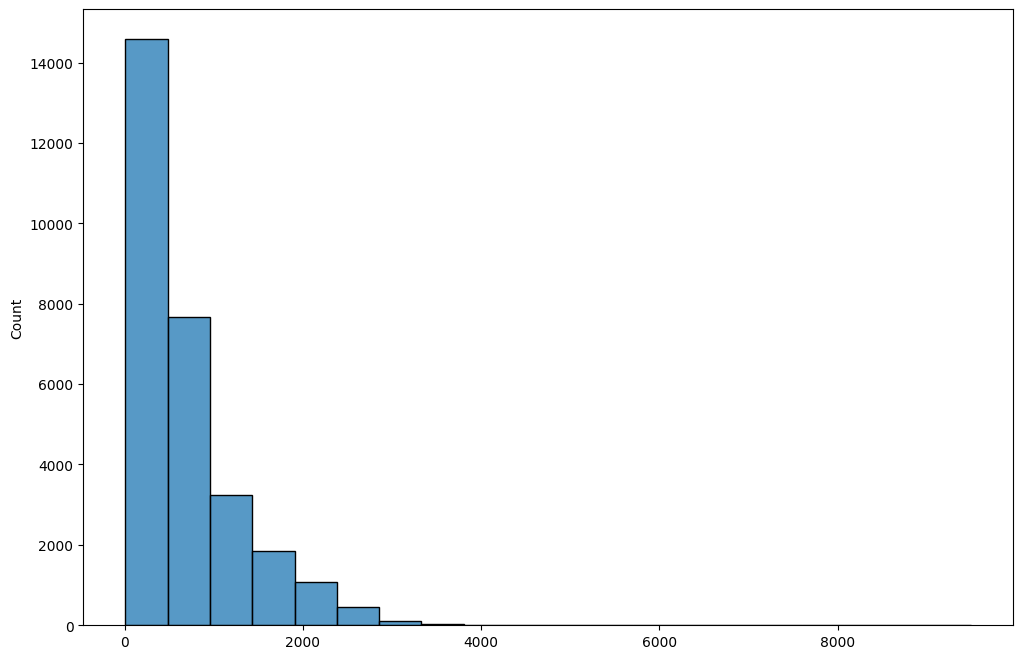

In [13]:
print('max words in a resume - ',max(str_lengths))
plt.figure(figsize=(12,8))
sns.histplot(str_lengths, bins = 20)
plt.show()

<Axes: ylabel='Count'>

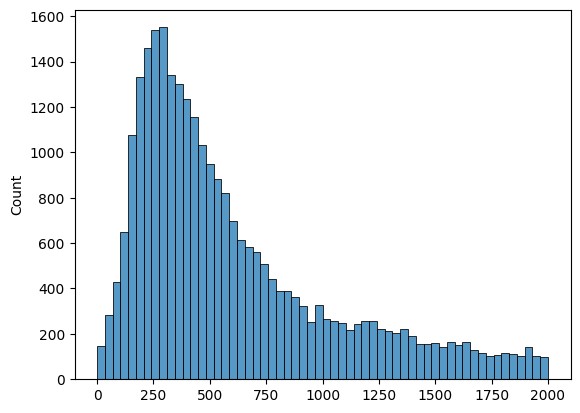

In [16]:
sns.histplot(str_lengths, binrange=(0,2000))

<Axes: ylabel='Count'>

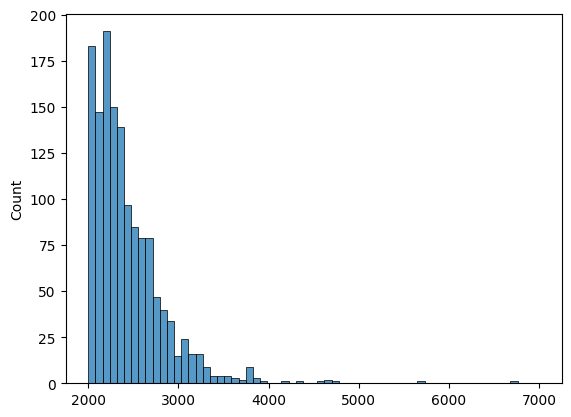

In [17]:
sns.histplot(str_lengths, binrange=(2000,7000))

<Axes: ylabel='Count'>

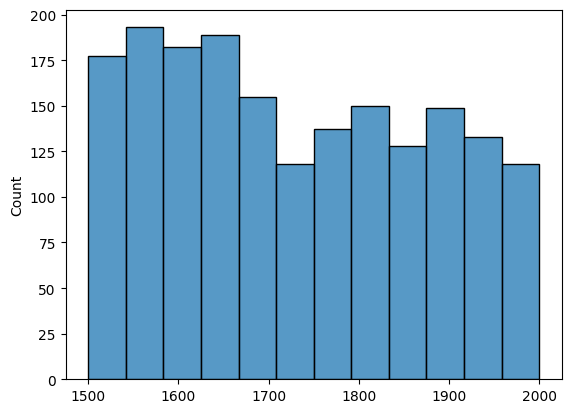

In [18]:
sns.histplot(str_lengths, binrange=(1500,2000))

<Axes: ylabel='Count'>

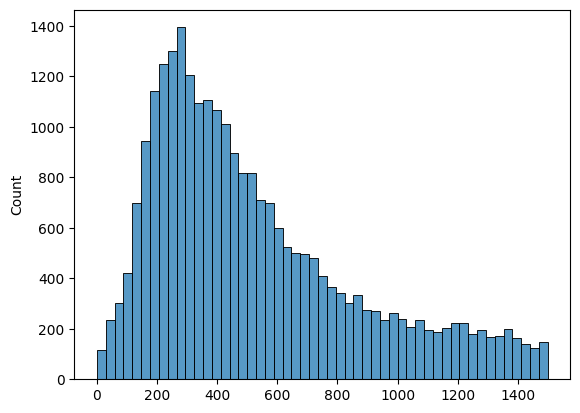

In [19]:
sns.histplot(str_lengths, binrange=(0,1500))

In [11]:
#taking index of those rows which have word count less than 1500 words. 
indx_1500 = np.where(str_lengths<1500)[0]
indx_1500

array([    0,     1,     2, ..., 29031, 29033, 29034])

In [12]:
df_1500 = df.iloc[indx_1500]
df_1500.reset_index(inplace = True)
df_1500

,index,txt,lab,cleaned_lab,cleaned_txt
0,0,"Database Administrator <span class=""hl"">Databa...",Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",database administrator database administrator ...
1,1,"Database Administrator <span class=""hl"">Databa...",Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",database administrator sql server database adm...
2,2,Oracle Database Administrator Oracle <span cla...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",oracle database administrator oracle oracle da...
3,3,Amazon Redshift Administrator and ETL Develope...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",amazon redshift administrator etl developer bu...
4,4,Scrum Master Scrum Master Scrum Master Richmon...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",scrum master scrum master scrum master richmon...
...,...,...,...,...,...
25815,29028,WordPress Developer/ Web Designer (Free-lancer...,"Web_Developer ,Software_Developer","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]",wordpress developer web designer freelancer wo...
25816,29029,"Web Developer and Designer <span class=""hl"">We...","Web_Developer ,Software_Developer ,Front_End_D...","[0, 1, 0, 0, 0, 1, 0, 1, 0, 0]",web developer designer designer web developer ...
25817,29031,"Android Developer Android <span class=""hl"">Dev...","Web_Developer ,Software_Developer","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]",android developer android android developer hc...
25818,29033,"Web Developer <span class=""hl"">Web</span> <spa...","Web_Developer ,Software_Developer","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]",web developer los angeles ca work experience w...


In [13]:
# df_1500[['cleaned_txt','lab','cleaned_lab']].to_csv('Cleaned_Resumes_n_lab_limit_1500.csv', index = False)
# saving the file

In [14]:
df_1500

,index,txt,lab,cleaned_lab,cleaned_txt
0,0,"Database Administrator <span class=""hl"">Databa...",Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",database administrator database administrator ...
1,1,"Database Administrator <span class=""hl"">Databa...",Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",database administrator sql server database adm...
2,2,Oracle Database Administrator Oracle <span cla...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",oracle database administrator oracle oracle da...
3,3,Amazon Redshift Administrator and ETL Develope...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",amazon redshift administrator etl developer bu...
4,4,Scrum Master Scrum Master Scrum Master Richmon...,Database_Administrator,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",scrum master scrum master scrum master richmon...
...,...,...,...,...,...
25815,29028,WordPress Developer/ Web Designer (Free-lancer...,"Web_Developer ,Software_Developer","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]",wordpress developer web designer freelancer wo...
25816,29029,"Web Developer and Designer <span class=""hl"">We...","Web_Developer ,Software_Developer ,Front_End_D...","[0, 1, 0, 0, 0, 1, 0, 1, 0, 0]",web developer designer designer web developer ...
25817,29031,"Android Developer Android <span class=""hl"">Dev...","Web_Developer ,Software_Developer","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]",android developer android android developer hc...
25818,29033,"Web Developer <span class=""hl"">Web</span> <spa...","Web_Developer ,Software_Developer","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]",web developer los angeles ca work experience w...


# Embeddings & converting text to vectors

In [101]:
# # saving all the text for embeddings
# df['cleaned_txt'].to_csv('Cleaned_resumes_without_lemm.txt',header = False, index = False)

In [99]:
# # saving cleaned text for Model building
# df_1500['cleaned_txt'].to_csv('Cleaned_resumes_without_lemm_1500words.txt',header = False, index = False)

## EMbeddings

In [16]:
ft_embeddings_150D = fasttext.train_unsupervised('Cleaned_resumes_without_lemm.txt', epoch = 20,dim = 150)
# ft_embeddings_200D = fasttext.load_model('ft_embeddings_200D.bin')

Read 20M words
Number of words:  46745
Number of labels: 0
Progress: 100.0% words/sec/thread:   74351 lr:  0.000000 avg.loss:  0.763505 ETA:   0h 0m 0s1.7% words/sec/thread:   74015 lr:  0.049171 avg.loss:  1.854010 ETA:   0h 8m 6s avg.loss:  1.255602 ETA:   0h 4m28s  0h 3m29s


In [26]:
ft_embeddings_150D.get_nearest_neighbors('python')

[(0.8184384107589722, 'django'),
 (0.7285428047180176, 'pythonxx'),
 (0.7064573764801025, 'pythonzope'),
 (0.7017067074775696, 'pythonui'),
 (0.7003216743469238, 'pythonusing'),
 (0.6878448724746704, 'pythonpostgresql'),
 (0.6863393783569336, 'flask'),
 (0.6840647459030151, 'usedpython'),
 (0.6818186044692993, 'pythonand'),
 (0.6792433261871338, 'pythonaws')]

In [17]:
ft_embeddings_150D.save_model('ft_embeddings_150D.bin')

## Converting resume text to vectors 

In [19]:
def get_embeddings(txt):
    txt_list = np.array(fasttext.tokenize(txt))

    z = [ft_embeddings_150D.get_word_vector(token) for token in txt_list]

    return np.array(z)

In [20]:
embeddings = {}
for row in range(df_1500.shape[0]):
    embeddings[row] = get_embeddings(df_1500['cleaned_txt'][row])

    we cannot convert the dictionary values into array bcoz of the varing length on the resumes. 
    
    to tackle this issue we will do the padding with zeros

In [21]:
max_len = max(str_lengths[np.where(str_lengths<1500)[0]])
print(max_len)

# so max word count in resumes under 1500 words in 1499 

1499


In [22]:
for key in embeddings.keys():
    len_difference = max_len - len(embeddings[key])

    pad = np.zeros(shape = (len_difference,150)) #because for the size of each word vector is 200

    embeddings[key] = np.concatenate([embeddings[key], pad])

In [23]:
embeddings = np.array(list(embeddings.values()))

In [27]:
embeddings.shape

(25820, 1499, 150)

In [3]:
import ast 
df = pd.read_csv('Cleaned_Resumes_n_lab_limit_1500.csv')
df['cleaned_lab'] = df['cleaned_lab'].apply(lambda x: x.replace(' ',','))
df['cleaned_lab'] = df['cleaned_lab'].apply(lambda x: ast.literal_eval(x))

In [4]:
# converting depended variable to appropriate datatype
y = np.vstack(df['cleaned_lab'].values)
y.shape
del(df)

In [6]:
with h5py.File('resume_embeddings_150D.h5', 'r') as hf:
    # Access features and labels datasets
    x_train = hf['resume_embeddings_150D'][:]

In [7]:
import dask.array as da
x_train = da.from_array(x_train, chunks = (1000,1000,1000))

In [11]:
# x_train, x_test, y_train, y_test = train_test_split(embeddings, y, test_size= 0.2, random_state= 42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y, test_size= 0.2, random_state= 42)

/Users/nikhilkudupudi/anaconda3/envs/env2/lib/python3.10/site-packages/sklearn/utils/__init__.py:184: PerformanceWarning: Slicing with an out-of-order index is generating 764 times more chunks
  return array[key] if axis == 0 else array[:, key]
/Users/nikhilkudupudi/anaconda3/envs/env2/lib/python3.10/site-packages/sklearn/utils/__init__.py:184: PerformanceWarning: Slicing with an out-of-order index is generating 192 times more chunks
  return array[key] if axis == 0 else array[:, key]


In [12]:
x_train.shape

(20656, 1499, 150)

In [13]:
print (x_train.shape, x_test.shape)
print (y_train.shape, y_test.shape)

(20656, 1499, 150) (5164, 1499, 150)
(20656, 10) (5164, 10)


## Saving the fasttext model and embeddings array for future use

In [29]:
# saving full embeddings data 
with h5py.File('resume_embeddings_150D.h5', 'w') as hf:
    hf.create_dataset('resume_embeddings_150D', data=embeddings)

In [97]:
# # saving training data
# with h5py.File('training_data.h5', 'w') as hf:
#     hf.create_dataset('x_train', data=x_train)
#     hf.create_dataset('y_train', data=y_train)

In [98]:
# # saving testing data
# with h5py.File('testing_data.h5', 'w') as hf:
#     hf.create_dataset('x_test', data=x_test)
#     hf.create_dataset('y_test', data=y_test)

In [100]:
# #saving fasttext embedding model
# ft_embeddings_50D.save_model('ft_embeddings_50D')

# Model Building

In [ ]:
### Loading .h5 files 

In [3]:
with h5py.File('resume_embeddings_50D.h5', 'r') as file:
    # Print the keys at the root level of the file
    print("Keys: ", list(file.keys()))

Keys:  ['resume_embeddings_50D']


In [29]:
# with h5py.File('resume_embeddings_50D.h5', 'r') as hf:
#     # Access features and labels datasets
#     x_train = hf['x_train'][:]
#     y_train = hf['y_train'][:]

# with h5py.File('testing_data.h5', 'r') as hf:
#     # Access features and labels datasets
#     x_test = hf['x_test'][:]
#     y_test = hf['y_test'][:]

In [ ]:
import dask.array as da 

x_train = da.from_array(x_train, chunks = (1000,1000,1000)) # text time try 100 from 3rd dimension
x_test = da.from_array(x_test, chunks = (1000,1000,1000))

x_train

In [39]:
y_train = da.from_array(y_train, chunks = (1000,1000))
y_test = da.from_array(y_test, chunks = (1000,1000))

In [43]:
print(type(y_train))

<class 'dask.array.core.Array'>


In [41]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(20656, 1499, 150) (20656, 10)
(5164, 1499, 150) (5164, 10)


In [15]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Input ,LSTM, Dropout,Flatten, Bidirectional,BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping

In [17]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [32]:
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred, precision, recall):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)

    f1 = 2 * (precision_value * recall_value) / (precision_value + recall_value + K.epsilon())
    return f1

@tf.function
def compiled_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, precision_metric, recall_metric)

2023-12-10 10:26:36.338543: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-12-10 10:26:36.338588: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-10 10:26:36.338592: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-10 10:26:36.338818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 10:26:36.339027: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Model Trained on 50D vectors

In [34]:
model_50d = Sequential()

model_50d.add(LSTM(128, return_sequences = True, input_shape = (1499,50)))
model_50d.add(Dropout(0.2))
model_50d.add(LSTM(128, return_sequences = True))
model_50d.add(Dropout(0.2))
model_50d.add(LSTM(128, return_sequences = True))
model_50d.add(Dropout(0.2))
model_50d.add(LSTM(128, return_sequences = True))
model_50d.add(Dropout(0.2))
model_50d.add(LSTM(128, return_sequences = True))
model_50d.add(Dropout(0.2))

model_50d.add(Flatten())

model_50d.add(Dense(128, activation = 'relu'))
model_50d.add(Dropout(0.2))
model_50d.add(Dense(32, activation = 'relu'))
model_50d.add(Dropout(0.2))
model_50d.add(Dense(10, activation='sigmoid'))

model_50d.summary()

early_stopping = EarlyStopping(monitor='val_compiled_f1_score', patience=3)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1499, 128)         91648     
                                                                 
 dropout_7 (Dropout)         (None, 1499, 128)         0         
                                                                 
 lstm_6 (LSTM)               (None, 1499, 128)         131584    
                                                                 
 dropout_8 (Dropout)         (None, 1499, 128)         0         
                                                                 
 lstm_7 (LSTM)               (None, 1499, 128)         131584    
                                                                 
 dropout_9 (Dropout)         (None, 1499, 128)         0         
                                                                 
 lstm_8 (LSTM)               (None, 1499, 128)        

In [35]:
model_50d.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=[compiled_f1_score, 'accuracy'])
model_50d.fit(x_train, y_train, epochs=5, batch_size= 64, validation_data=( x_test, y_test), callbacks=[early_stopping])

Epoch 1/5


2023-12-10 10:28:48.169915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


323/323 [==============================] - 238s 722ms/step - loss: 80.7041 - compiled_f1_score: 0.3188 - accuracy: 0.3858 - val_loss: 77.2077 - val_compiled_f1_score: 0.3591 - val_accuracy: 0.5043
Epoch 2/5
323/323 [==============================] - 230s 710ms/step - loss: 75.2857 - compiled_f1_score: 0.3772 - accuracy: 0.4707 - val_loss: 38.3922 - val_compiled_f1_score: 0.3898 - val_accuracy: 0.5037
Epoch 3/5
323/323 [==============================] - 230s 710ms/step - loss: 38.9724 - compiled_f1_score: 0.3972 - accuracy: 0.4899 - val_loss: 20.7380 - val_compiled_f1_score: 0.4051 - val_accuracy: 0.5205
Epoch 4/5
323/323 [==============================] - 229s 708ms/step - loss: 21.8914 - compiled_f1_score: 0.4125 - accuracy: 0.5236 - val_loss: 13.5520 - val_compiled_f1_score: 0.4197 - val_accuracy: 0.6313


In [36]:
model_50d.fit(x_train, y_train, epochs=10, batch_size= 64, validation_data=( x_test, y_test), callbacks=[early_stopping])

Epoch 1/10
323/323 [==============================] - 230s 709ms/step - loss: 15.4033 - compiled_f1_score: 0.4238 - accuracy: 0.4991 - val_loss: 11.3231 - val_compiled_f1_score: 0.4243 - val_accuracy: 0.3923
Epoch 2/10
323/323 [==============================] - 229s 706ms/step - loss: 11.2763 - compiled_f1_score: 0.4225 - accuracy: 0.4460 - val_loss: 8.6912 - val_compiled_f1_score: 0.4215 - val_accuracy: 0.4251
Epoch 3/10
323/323 [==============================] - 234s 722ms/step - loss: 9.8750 - compiled_f1_score: 0.4198 - accuracy: 0.4298 - val_loss: 7.5030 - val_compiled_f1_score: 0.4182 - val_accuracy: 0.4018
Epoch 4/10
323/323 [==============================] - 229s 708ms/step - loss: 7.3003 - compiled_f1_score: 0.4163 - accuracy: 0.3967 - val_loss: 7.2984 - val_compiled_f1_score: 0.4135 - val_accuracy: 0.4560
Epoch 5/10
 34/323 [==>...........................] - ETA: 3:08 - loss: 7.1251 - compiled_f1_score: 0.4131 - accuracy: 0.3911

KeyboardInterrupt: 

In [38]:
y_pred = model_50d.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [42]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.42      0.55      0.48       608
           1       0.84      0.80      0.82      2454
           2       0.00      0.00      0.00      1213
           3       0.00      0.00      0.00       873
           4       0.00      0.00      0.00       560
           5       0.23      1.00      0.37      1128
           6       0.00      0.00      0.00       884
           7       0.00      0.00      0.00       707
           8       0.00      0.00      0.00       364
           9       0.00      0.00      0.00       387

   micro avg       0.43      0.37      0.40      9178
   macro avg       0.15      0.24      0.17      9178
weighted avg       0.28      0.37      0.30      9178
 samples avg       0.34      0.34      0.32      9178



/Users/nikhilkudupudi/anaconda3/envs/env2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nikhilkudupudi/anaconda3/envs/env2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
model_50d.save('LSTM_model_50d.h5')

/Users/nikhilkudupudi/anaconda3/envs/env2/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model trained on 150D vectors 

In [16]:
model_150d = Sequential()

model_150d.add(Bidirectional(LSTM(128, return_sequences = True), input_shape = (1499,150)))
model_150d.add(BatchNormalization())
model_150d.add(Dropout(0.2))

model_150d.add(Bidirectional(LSTM(256, return_sequences = True)))
model_150d.add(BatchNormalization())
model_150d.add(Dropout(0.2))

model_150d.add(Bidirectional(LSTM(256,return_sequences = True)))
model_150d.add(BatchNormalization())
model_150d.add(Dropout(0.2))

model_150d.add(LSTM(128))
model_150d.add(Dropout(0.2))

model_150d.add(Flatten())

model_150d.add(Dense(128, activation = 'relu'))
model_150d.add(BatchNormalization())
model_150d.add(Dropout(0.2))

model_150d.add(Dense(32, activation = 'relu'))
model_150d.add(Dropout(0.2))
model_150d.add(Dense(10, activation='sigmoid'))

model_150d.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

2023-12-10 12:10:22.244407: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-12-10 12:10:22.244742: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-10 12:10:22.244754: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-10 12:10:22.245240: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 12:10:22.245538: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1499, 256)         285696    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 1499, 256)         1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1499, 256)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 1499, 512)         1050624   
 onal)                                                           
                                                                 
 batch_normalization_1 (Bat  (None, 1499, 512)         2048      
 chNormalization)                                       

In [17]:
model_150d.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

model_150d.fit(x_train, y_train, epochs=8, batch_size=32, validation_data=(x_train, y_train), callbacks=[early_stopping])

Epoch 1/8


2023-12-10 12:10:42.211759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


646/646 [==============================] - 1057s 2s/step - loss: 0.4712 - accuracy: 0.4087 - val_loss: 0.8148 - val_accuracy: 0.4622
Epoch 2/8
646/646 [==============================] - 1060s 2s/step - loss: 0.3646 - accuracy: 0.5335 - val_loss: 0.3996 - val_accuracy: 0.5045
Epoch 3/8
646/646 [==============================] - 1062s 2s/step - loss: 0.3165 - accuracy: 0.6059 - val_loss: 0.3640 - val_accuracy: 0.5481
Epoch 4/8
646/646 [==============================] - 1064s 2s/step - loss: 0.3007 - accuracy: 0.6596 - val_loss: 0.3154 - val_accuracy: 0.6250
Epoch 5/8
646/646 [==============================] - 1085s 2s/step - loss: 0.2865 - accuracy: 0.7113 - val_loss: 0.4514 - val_accuracy: 0.4213
Epoch 6/8
646/646 [==============================] - 1081s 2s/step - loss: 0.2774 - accuracy: 0.7310 - val_loss: 0.3786 - val_accuracy: 0.5225
Epoch 7/8
646/646 [==============================] - 1079s 2s/step - loss: 0.2666 - accuracy: 0.7583 - val_loss: 0.7228 - val_accuracy: 0.2586
Epoch 8/8

KeyboardInterrupt: 

In [18]:
from sklearn.metrics import classification_report, accuracy_score

In [19]:
y_pred = model_150d.predict(x_test)

162/162 [==============================] - 58s 338ms/step


In [20]:
y_pred

array([[4.16148528e-02, 7.41502829e-03, 6.28524303e-01, ...,
        2.09983997e-03, 2.96775741e-03, 1.68003223e-03],
       [4.80205983e-01, 7.72464275e-01, 4.01987545e-02, ...,
        1.16949109e-02, 2.10188143e-02, 1.47163182e-01],
       [4.59040739e-02, 9.10207350e-03, 7.67460585e-01, ...,
        1.32462871e-03, 2.89377291e-03, 3.44133028e-03],
       ...,
       [4.76166978e-02, 9.62737381e-01, 2.51916703e-02, ...,
        1.13764696e-01, 6.35520667e-02, 1.23441540e-01],
       [8.94299820e-02, 8.45470838e-03, 7.67810643e-01, ...,
        8.72744189e-04, 2.73243082e-03, 4.96330718e-03],
       [3.05591971e-01, 8.91427100e-01, 3.69512029e-02, ...,
        2.46278588e-02, 3.54406796e-02, 2.00882241e-01]], dtype=float32)

In [23]:
y_pred = (y_pred > 0.4).astype(int)

In [24]:
accuracy_score(y_test, y_pred)

0.12838884585592564

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.24      0.72      0.36       608
           1       1.00      0.48      0.64      2454
           2       0.43      0.94      0.59      1213
           3       0.54      0.29      0.38       873
           4       0.94      0.29      0.44       560
           5       0.00      0.00      0.00      1128
           6       0.40      0.92      0.55       884
           7       0.00      0.00      0.00       707
           8       0.00      0.00      0.00       364
           9       0.00      0.00      0.00       387

   micro avg       0.48      0.43      0.45      9178
   macro avg       0.35      0.36      0.30      9178
weighted avg       0.49      0.43      0.39      9178
 samples avg       0.49      0.49      0.45      9178



/Users/nikhilkudupudi/anaconda3/envs/env2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nikhilkudupudi/anaconda3/envs/env2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1])

In [29]:
model_150d.save('model_150D.keras')